In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns
import matplotlib.colors as mcolors

from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr, zscore, chi2_contingency

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [2]:
# 1. load all data files and pair them as a corpus
data_files = os.listdir("data")
reward_df_files = sorted(
    [f for f in data_files if "scoredreward_humanassistant_includeprompt" in f]
)
nll_df_files = sorted(
    [f for f in data_files if "scorednll" in f and "includeprompt" not in f]
)
correction_files = sorted([f for f in data_files if "scoredcorrectionnll" in f])

triplet_files = [
    (r, n, c) for r, n, c in zip(reward_df_files, nll_df_files, correction_files)
]
assert len(reward_df_files) == len(nll_df_files) == len(correction_files)

for r, n, c in triplet_files:
    print()
    print(r)
    print(n)
    print(c)


ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scorednll.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scoredcorrectionnll_ancestral_strict_1.0_humanassistant_includeprompt_conditioned.csv

ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredcorrectionnll_ancestral_1.0_humanassistant_includeprompt_conditioned.csv

ethz-spylab-rlhf-7b-harmless_l256_promptseed42_nu

In [10]:
# 2. set parameters
num_corpuses = 5000
num_samples_per_corpus = 5000
metropolis_steps = 50_000

colours = sorted(
    list(mcolors.TABLEAU_COLORS.keys())
    + list(mcolors.BASE_COLORS.keys())
    + list(mcolors.CSS4_COLORS.keys())
)
names = [
    "ancestral_t1.0",
    "k50_t1.0",
    "k50_t1.5",
    "k50_t2.0",
    "eta_n00009_t1.0",
    "eta_n00009_t1.5",
    "eta_n00009_t2.0",
    "top_k30_t1.0",
    "top_k30_t1.5",
    "top_k30_t2.0",
    "p090_t1.0",
    "p090_t1.5",
    "p090_t2.0",
    "p095_t1.0",
    "p095_t1.5",
    "p095_t2.0",
    "typical_p090_t1.0",
    "typical_p090_t1.5",
    "typical_p090_t2.0",
]
assert len(colours) >= len(triplet_files)
assert len(names) == len(triplet_files)

In [11]:
# for idx, (reward_df_file, nll_df_file, correction_df_file) in enumerate(triplet_files):
#     print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")
#     # 3.1 load and merge
#     reward_df = pd.read_csv(f"data/{reward_df_file}")
#     nll_df = pd.read_csv(f"data/{nll_df_file}")
#     correction_df = pd.read_csv(f"data/{correction_df_file}")

#     df = reward_df.merge(nll_df, on=["prompt", "generated_text"], how="inner").merge(
#         correction_df, on=["prompt", "generated_text"], how="inner"
#     )

#     # 3.1.1 get log probability
#     df["log_probability"] = -df["negative_log_probability"]

#     # 3.1.2 filter duplicates, empty strings, invalid probabilities
#     df = df[df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)]
#     df = df[df["negative_log_probability"].isin([-np.inf, np.inf]) == False]
#     df = df[df["negative_log_probability"].isnull() == False]
#     df = df[df["score"].isin([-np.inf, np.inf]) == False]
#     df = df[df["score"].isnull() == False]
#     df_maybe_duplicates = df.copy()
#     df = df.drop_duplicates()
#     assert len(df) > 0
#     print(f"Length: {len(df)}")
#     print(tabulate(df.head(), headers="keys", tablefmt="psql"))
#     print(
#         tabulate(
#             df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
#         )
#     )

#     # 3.4 metropolis corpus level
#     print("===== Metropolis corpus level statistics =====")
#     # 3.4.1.1 metropolis
#     # see https://www.statlect.com/fundamentals-of-statistics/Metropolis-Hastings-algorithm
#     # see https://projecteuclid.org/journals/annals-of-statistics/volume-24/issue-1/Rates-of-convergence-of-the-Hastings-and-Metropolis-algorithms/10.1214/aos/1033066201.full
#     metropolis_df = None
#     shuffled_df = df_maybe_duplicates.sample(frac=1, random_state=0)
#     shuffled_df = df_maybe_duplicates.sample(
#         n=metropolis_steps, random_state=0, replace=True
#     )
#     acceptance_thresholds = np.random.uniform(0.0, 1.0, size=len(shuffled_df))
#     acceptance_count = 0
#     start = shuffled_df.iloc[0]
#     prev = start
#     for step in range(1, len(shuffled_df)):
#         sample = shuffled_df.iloc[step]
#         acceptance = (
#             min(
#                 1.0,
#                 (
#                     np.exp(
#                         np.array(
#                             -sample["original_negative_log_probability"]
#                             - prev["samplingbiased_negative_log_probability"]
#                             + prev["original_negative_log_probability"]
#                             + sample["samplingbiased_negative_log_probability"]
#                         ).astype(np.float128)
#                     ).item()
#                 ),
#             )
#             > acceptance_thresholds[step],
#         )
#         if acceptance:
#             acceptance_count += 1
#             prev = sample
#             to_add = df[
#                 (df["prompt"] == sample["prompt"])
#                 & (df["generated_text"] == sample["generated_text"])
#             ]
#         else:
#             to_add = df[
#                 (df["prompt"] == prev["prompt"])
#                 & (df["generated_text"] == prev["generated_text"])
#             ]
#         if metropolis_df is None:
#             metropolis_df = to_add
#         else:
#             metropolis_df = pd.concat([metropolis_df, to_add])
#     algorithm_acceptance_rate = acceptance_count / len(shuffled_df)
#     print(f"Algorithm acceptance rate: {algorithm_acceptance_rate}")

#     # 3.4.1.2 compute categorical autocorrelation
#     # cramer's v: https://stats.stackexchange.com/questions/438279/autocorrelation-for-a-categorical-time-series
#     # see transition matrix based test of convergence in https://arxiv.org/abs/1706.04919
#     states, promptandtexts = pd.factorize(
#         shuffled_df.apply(
#             lambda row: f"{row['prompt']};;;{row['generated_text']}", axis=1
#         )
#     )
#     promptandtext2state = {
#         promptandtext: state
#         for promptandtext, state in zip(
#             set(promptandtexts.to_numpy().tolist()), set(states.tolist())
#         )
#     }
#     unique_states = list(set(states))
#     transition_matrix = np.zeros((len(unique_states), len(unique_states)))
#     transition_sequence = (
#         pd.concat([start.to_frame().T, metropolis_df]).apply(
#             lambda row: promptandtext2state[
#                 f"{row['prompt']};;;{row['generated_text']}"
#             ],
#             axis=1,
#         )
#     ).to_numpy()
#     for i in range(1, len(transition_sequence)):
#         transition_matrix[transition_sequence[i - 1], transition_sequence[i]] += 1

#     # remove rows and cols with only zero
#     transition_matrix = transition_matrix[~np.all(transition_matrix == 0, axis=1)]
#     transition_matrix = transition_matrix[:, ~np.all(transition_matrix == 0, axis=0)]

#     # cramer's v
#     X2 = chi2_contingency(transition_matrix, correction=False)[0]
#     N = np.sum(transition_matrix)
#     min_dim = min(transition_matrix.shape) - 1
#     cramer = np.sqrt(X2 / (N * min_dim))
#     print(f"Cramer's V: {cramer}")

#     break



Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scorednll.csv:
Length: 1948
+----+----------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

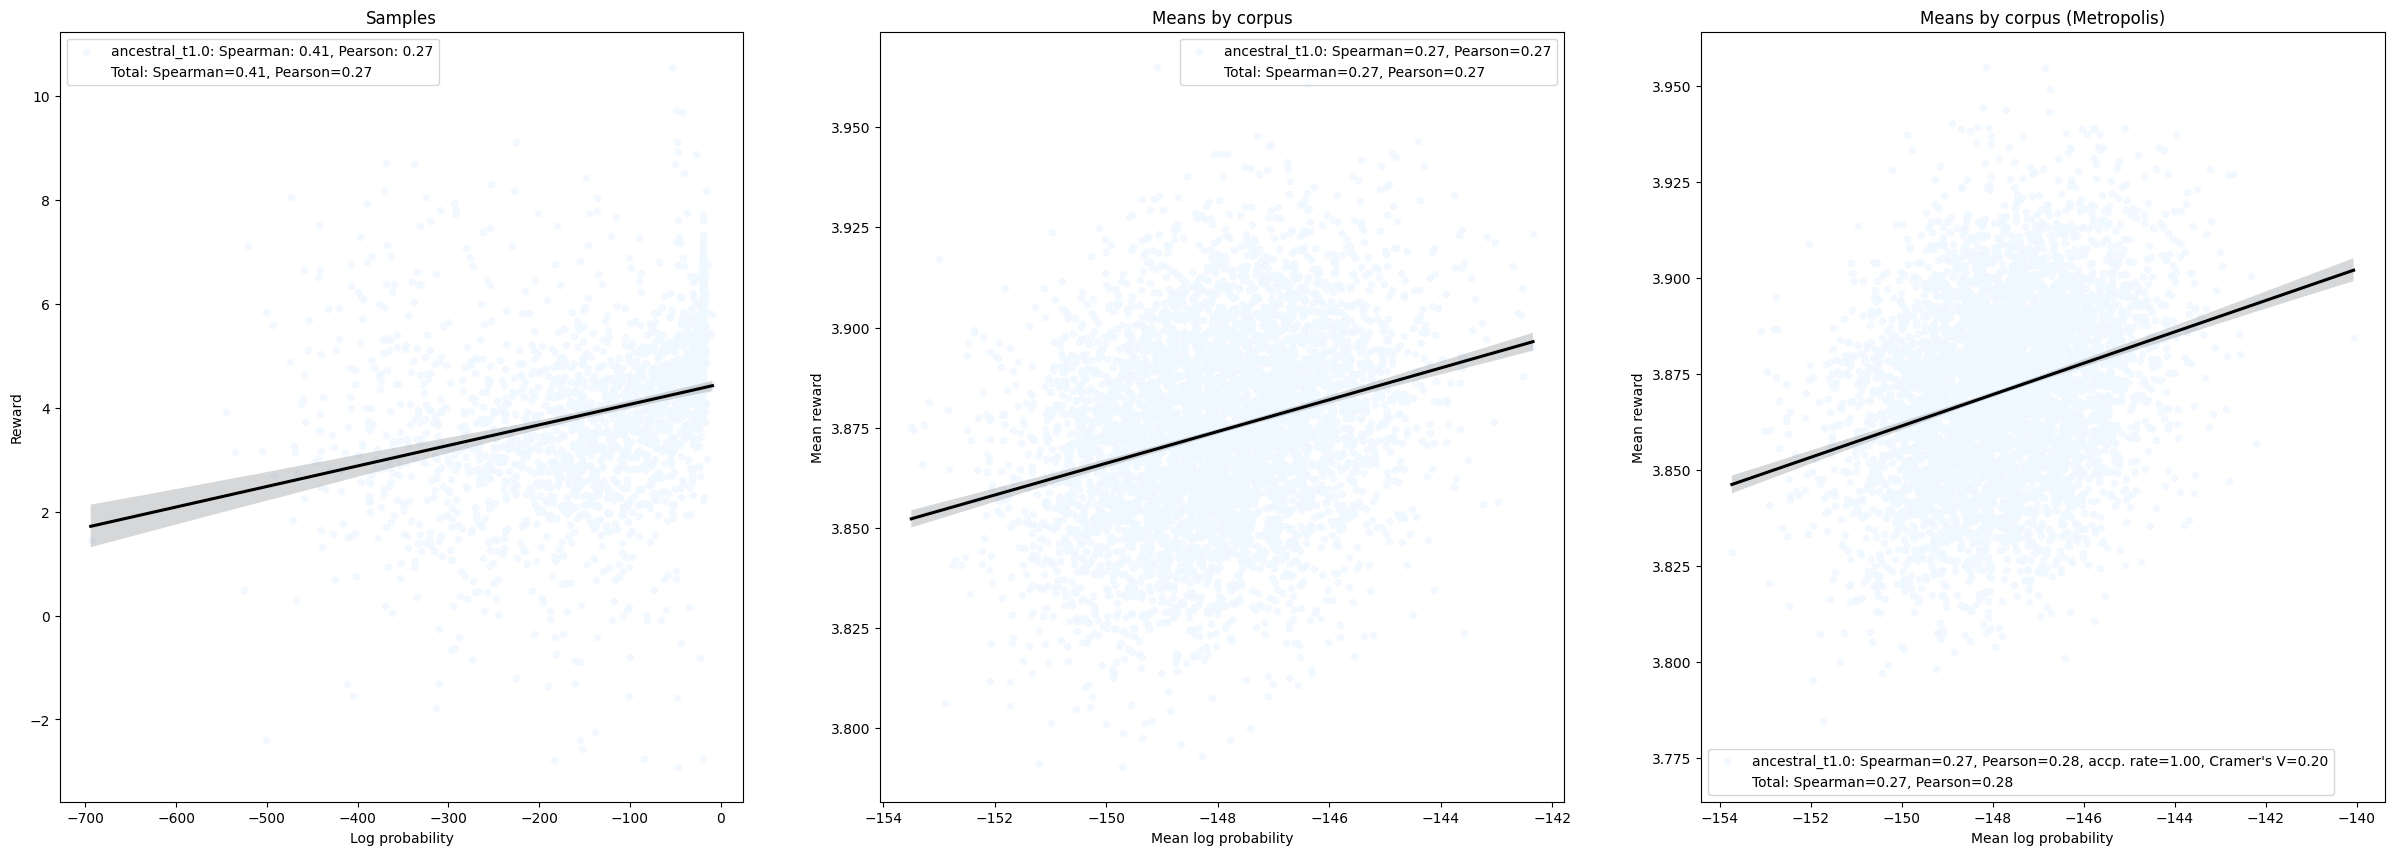

In [12]:
# 3. analysis on each corpus
# 3.0 a single output figure
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
total_mean_corpuses = None
total_corpus = None
total_mean_corrected_corpuses = None
total_mean_metropolis_corpuses = None
acceptance_rates = dict()
for idx, (reward_df_file, nll_df_file, correction_df_file) in enumerate(triplet_files):
    print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")
    # 3.1 load and merge
    reward_df = pd.read_csv(f"data/{reward_df_file}")
    nll_df = pd.read_csv(f"data/{nll_df_file}")
    correction_df = pd.read_csv(f"data/{correction_df_file}")

    df = reward_df.merge(nll_df, on=["prompt", "generated_text"], how="inner").merge(
        correction_df, on=["prompt", "generated_text"], how="inner"
    )

    # 3.1.1 get log probability
    df["log_probability"] = -df["negative_log_probability"]

    # 3.1.2 filter duplicates, empty strings, invalid probabilities
    df = df[df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)]
    df = df[df["negative_log_probability"].isin([-np.inf, np.inf]) == False]
    df = df[df["negative_log_probability"].isnull() == False]
    df = df[df["score"].isin([-np.inf, np.inf]) == False]
    df = df[df["score"].isnull() == False]
    df_maybe_duplicates = df.copy()
    df = df.drop_duplicates()
    assert len(df) > 0
    print(f"Length: {len(df)}")
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))
    print(
        tabulate(
            df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
        )
    )

    # 3.2 Sample level
    print("===== Sample level statistics =====")
    # 3.2.1 Scatter
    spearman = spearmanr(df["score"], df["log_probability"])
    pearson = pearsonr(df["score"], df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    df.plot.scatter(
        y="score",
        x="log_probability",
        title="Samples",
        ax=axs[0],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman: {spearman[0]:.2f}, Pearson: {pearson[0]:.2f}",
    )
    # 3.2.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=df,
        ax=axs[0],
        scatter=False,
        color=colours[idx],
    )
    if total_corpus is None:
        total_corpus = df
    else:
        total_corpus = pd.concat([total_corpus, df])

    # 3.3 Corpus level
    print("===== Corpus level statistics =====")
    # 3.3.1 Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    pearson = pearsonr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus",
        ax=axs[1],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corpuses is None:
        total_mean_corpuses = mean_corpuses_df
    else:
        total_mean_corpuses = pd.concat([total_mean_corpuses, mean_corpuses_df])

    # 3.3.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=mean_corpuses_df,
        ax=axs[1],
        scatter=False,
        color=colours[idx],
    )

    # 3.4 metropolis corpus level
    print("===== Metropolis corpus level statistics =====")
    # 3.4.1.1 metropolis
    # see https://www.statlect.com/fundamentals-of-statistics/Metropolis-Hastings-algorithm
    # see https://projecteuclid.org/journals/annals-of-statistics/volume-24/issue-1/Rates-of-convergence-of-the-Hastings-and-Metropolis-algorithms/10.1214/aos/1033066201.full
    metropolis_df = None
    # shuffled_df = df_maybe_duplicates.sample(frac=1, random_state=0)
    shuffled_df = df.sample(n=metropolis_steps, random_state=0, replace=True)
    # shuffled_df = (
    #     df.groupby(["prompt"], as_index=False)
    #     .apply(
    #         lambda x: x.sample(
    #             int(np.ceil(metropolis_steps / len(df["prompt"].unique()))),
    #             random_state=0,
    #             replace=True,
    #         )
    #     )
    #     .sample(frac=1, random_state=0)
    # )

    acceptance_thresholds = np.random.uniform(0.0, 1.0, size=len(shuffled_df))
    acceptance_count = 0
    start = shuffled_df.iloc[0]
    prev = start
    for step in range(1, len(shuffled_df)):
        sample = shuffled_df.iloc[step]
        acceptance = (
            min(
                1.0,
                (
                    np.exp(
                        np.array(
                            -sample["original_negative_log_probability"]
                            - prev["samplingbiased_negative_log_probability"]
                            + prev["original_negative_log_probability"]
                            + sample["samplingbiased_negative_log_probability"]
                        ).astype(np.float128)
                    ).item()
                ),
            )
            > acceptance_thresholds[step],
        )
        if acceptance:
            acceptance_count += 1
            prev = sample
            to_add = df[
                (df["prompt"] == sample["prompt"])
                & (df["generated_text"] == sample["generated_text"])
            ]
        else:
            to_add = df[
                (df["prompt"] == prev["prompt"])
                & (df["generated_text"] == prev["generated_text"])
            ]
        if metropolis_df is None:
            metropolis_df = to_add
        else:
            metropolis_df = pd.concat([metropolis_df, to_add])
    algorithm_acceptance_rate = acceptance_count / len(shuffled_df)
    print(f"Algorithm acceptance rate: {algorithm_acceptance_rate}")

    # 3.4.1.2 compute categorical autocorrelation
    # cramer's v: https://stats.stackexchange.com/questions/438279/autocorrelation-for-a-categorical-time-series
    # see transition matrix based test of convergence in https://arxiv.org/abs/1706.04919
    states, promptandtexts = pd.factorize(
        shuffled_df.apply(
            lambda row: f"{row['prompt']};;;{row['generated_text']}", axis=1
        )
    )
    promptandtext2state = {
        promptandtext: state
        for promptandtext, state in zip(
            set(promptandtexts.to_numpy().tolist()), set(states.tolist())
        )
    }
    unique_states = list(set(states))
    transition_matrix = np.zeros((len(unique_states), len(unique_states)))
    transition_sequence = (
        pd.concat([start.to_frame().T, metropolis_df]).apply(
            lambda row: promptandtext2state[
                f"{row['prompt']};;;{row['generated_text']}"
            ],
            axis=1,
        )
    ).to_numpy()
    for i in range(1, len(transition_sequence)):
        transition_matrix[transition_sequence[i - 1], transition_sequence[i]] += 1

    # remove rows and cols with only zero
    transition_matrix = transition_matrix[~np.all(transition_matrix == 0, axis=1)]
    transition_matrix = transition_matrix[:, ~np.all(transition_matrix == 0, axis=0)]

    # cramer's v
    X2 = chi2_contingency(transition_matrix, correction=False)[0]
    N = np.sum(transition_matrix)
    min_dim = min(transition_matrix.shape) - 1
    cramer = np.sqrt(X2 / (N * min_dim))
    print(f"Cramer's V: {cramer}")

    # 3.4.2 Sample corpuses
    corpuses = {
        corpus_seed: metropolis_df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T

    spearman = spearmanr(
        mean_corpuses_df["score"],
        mean_corpuses_df["log_probability"],
    )
    pearson = pearsonr(
        mean_corpuses_df["score"],
        mean_corpuses_df["log_probability"],
    )
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus (Metropolis)",
        ax=axs[2],
        c=colours[idx],
        alpha=0.8,
        label=(
            f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}, accp."
            f" rate={algorithm_acceptance_rate:.2f}, Cramer's V={cramer:.2f}"
        ),
    )
    if total_mean_metropolis_corpuses is None:
        total_mean_metropolis_corpuses = mean_corpuses_df
    else:
        total_mean_metropolis_corpuses = pd.concat(
            [total_mean_metropolis_corpuses, mean_corpuses_df]
        )

    # 3.4.3 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=mean_corpuses_df,
        ax=axs[2],
        scatter=False,
        color=colours[idx],
    )
    break


# 4. Total corpus level statistics
# 4.1 sample
print("===== Total corpus level statistics =====")
spearman = spearmanr(total_corpus["score"], total_corpus["log_probability"])
pearson = pearsonr(total_corpus["score"], total_corpus["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_corpus.plot.scatter(
    y="score",
    x="log_probability",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[0],
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_corpus,
    scatter=False,
    color="black",
    ax=axs[0],
)
axs[0].set_ylabel("Reward")
axs[0].set_xlabel("Log probability")

# 4.2 corpus
print("===== Total corpus mean statistics =====")
spearman = spearmanr(
    total_mean_corpuses["score"], total_mean_corpuses["log_probability"]
)
pearson = pearsonr(total_mean_corpuses["score"], total_mean_corpuses["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_mean_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[1],
    ylabel="Mean score",
    xlabel="Mean log probability",
)

sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_corpuses,
    scatter=False,
    color="black",
    ax=axs[1],
)
axs[1].set_ylabel("Mean reward")
axs[1].set_xlabel("Mean log probability")

# 4.3 corrected metropolis corpus
print("===== Total metropolis corpus mean statistics =====")
spearman = spearmanr(
    total_mean_metropolis_corpuses["score"],
    total_mean_metropolis_corpuses["log_probability"],
)
pearson = pearsonr(
    total_mean_metropolis_corpuses["score"],
    total_mean_metropolis_corpuses["log_probability"],
)
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_mean_metropolis_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus (Metropolis)",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[2],
    ylabel="Mean reward",
    xlabel="Mean log probability",
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_metropolis_corpuses,
    scatter=False,
    color="black",
    ax=axs[2],
)
axs[2].set_ylabel("Mean reward")
axs[2].set_xlabel("Mean log probability")

plt.legend()
plt.show()
plt.close()